In [1]:
import pandas as pd
import numpy as np
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
conference =  pd.read_csv('conference.csv')
game_statistics = pd.read_csv('game-statistics.csv')
drive = pd.read_csv('drive.csv')
game = pd.read_csv('game.csv')
kickoff_return = pd.read_csv('kickoff-return.csv')
kickoff = pd.read_csv('kickoff.csv')
ppass = pd.read_csv('pass.csv')
play = pd.read_csv('play.csv')
player_game_statistics = pd.read_csv('player-game-statistics.csv')
player = pd.read_csv('player.csv')
punt_return = pd.read_csv('punt-return.csv')
punt = pd.read_csv('punt.csv')
reception = pd.read_csv('reception.csv')
rush = pd.read_csv('rush.csv')
stadium = pd.read_csv('stadium.csv')
team_game_statistics = pd.read_csv('team-game-statistics.csv')
team = pd.read_csv('team.csv')

In [3]:
team_game_statistics[team_game_statistics['Game Code'] == 690002820050901]

,Team Code,Game Code,Rush Att,Rush Yard,Rush TD,Pass Att,Pass Comp,Pass Yard,Pass TD,Pass Int,...,Time Of Possession,Penalty,Penalty Yard,Third Down Att,Third Down Conv,Fourth Down Att,Fourth Down Conv,Red Zone Att,Red Zone TD,Red Zone Field Goal
36,28,690002820050901,44,300,4,31,19,259,5,2,...,1798,11,101,11,7,1,1,8,7,0
1080,690,690002820050901,35,62,1,37,18,203,1,2,...,1802,0,0,16,7,1,0,3,2,0


In [4]:
games = play['Game Code'].unique().tolist()

In [5]:
'''The team game statistics, as comprehensive as it is, seems to lack one important feature: if the team won or lost. Therefore
I needed to come up with a way to find the label of a win or a loss. In order to do this, I came up with a system where
I go through each of the games, and find the last row, which is the last play of the game. I can then take the data from this
data frame and combine it with the team game statistics data frame, matching on the Game Code. 
'''
df = pd.DataFrame(columns = play.columns)
for game in games:
    df = df.append(play[play['Game Code'] == game][-1:])

In [6]:
'''Here is the data frame of the final plays for each game, and therefore the final scores. 
'''
df.head()

,Game Code,Play Number,Period Number,Clock,Offense Team Code,Defense Team Code,Offense Points,Defense Points,Down,Distance,Spot,Play Type,Drive Number,Drive Play
195,690002820050901,196,4,36.0,690,28,16,63,1.0,10.0,76,RUSH,31.0,1.0
389,204014020050901,194,4,18.0,140,204,28,26,1.0,10.0,60,RUSH,24.0,1.0
554,86016420050901,165,4,NaN,164,86,38,0,3.0,6.0,14,RUSH,25.0,1.0
765,529028820050901,211,4,3.0,288,529,24,38,NaN,NaN,65,KICKOFF,NaN,NaN
948,786038820050901,183,4,NaN,388,786,36,24,2.0,14.0,29,RUSH,27.0,1.0


In [7]:
newDF = pd.merge(team_game_statistics, df, on = 'Game Code')

In [8]:
'''This is the function that lets me find if the team in question, as identified by team_code, won or lost the game. 
I first match up if the team_code corresponds to the team on offense or the team on defense, and then ask if the offense
or defense had more points, returning 1 for a win and 0 for a loss. 
'''
def win_or_loss(team_code,offense_code, defense_code, offense_points, defense_points):
    if team_code == offense_code:
        if offense_points > defense_points:
            return 1
        else:
            return 0
    if team_code == defense_code:
        if defense_points > offense_points:
            return 1
        else:
            return 0

In [9]:
'''This is where I create the new win or loss column, passing in the needed features
'''
newDF['W/L'] = newDF.apply(lambda row: win_or_loss(row['Team Code'], row['Offense Team Code'],
                                                   row['Defense Team Code'], row['Offense Points'], 
                                                   row['Defense Points']), axis = 1)

In [10]:
'''This data frame is just to show that the added W/L column correctly labels the game as a win or a loss
'''
newDF[['Game Code','Team Code','Offense Team Code','Defense Team Code','Offense Points','Defense Points','W/L']].head(20)

,Game Code,Team Code,Offense Team Code,Defense Team Code,Offense Points,Defense Points,W/L
0,5055920050910,5,559,5,49,24,0
1,5055920050910,559,559,5,49,24,1
2,5041920050917,5,5,419,17,7,1
3,5041920050917,419,5,419,17,7,0
4,503000520050924,5,5,503,42,42,0
5,503000520050924,503,5,503,42,42,0
6,129000520051001,5,129,5,31,17,0
7,129000520051001,129,129,5,31,17,1
8,5008620051008,5,5,86,13,7,1
9,5008620051008,86,5,86,13,7,0


In [11]:
'''This is the only instance in the whole dataset where the is lacking information. If a game went to overtime, there was no
information on what happened in overtime; this dataset only recorded the first 60 minutes of the game. Therefore, I don't have
an accurate way of saying if a team won or lost. I decided that the number of games that went to overtime was small enough in
reference to the rest of the games, and was therefore not necessary to find supplemental  information to add. Therefore, I just
removed games that were in a draw at the end of the first 60 minutes.
'''
draws = newDF[(newDF['Offense Points'] == newDF['Defense Points'])]['Game Code'].unique().tolist()

In [12]:
'''Remove the games that ended regulation time in a tie
'''
filtered = newDF[~newDF['Game Code'].isin(draws)]

'''The keep list are the features in which I am going to use to train the model. While I could have instead made a list of 
features that I DO NOT want to use for model training (like game code, team code, etc), I felt it was more appropriate 
to outline the features  here for easy visibility. 
'''
keep = ['Rush Att', 'Rush Yard', 'Rush TD',
       'Pass Att', 'Pass Comp', 'Pass Yard', 'Pass TD', 'Pass Int',
       'Pass Conv', 'Kickoff Ret', 'Kickoff Ret Yard', 'Kickoff Ret TD',
       'Punt Ret', 'Punt Ret Yard', 'Punt Ret TD', 'Fum Ret', 'Fum Ret Yard',
       'Fum Ret TD', 'Int Ret', 'Int Ret Yard', 'Int Ret TD', 'Misc Ret',
       'Misc Ret Yard', 'Misc Ret TD', 'Field Goal Att', 'Field Goal Made',
       'Off XP Kick Att', 'Off XP Kick Made', 'Off 2XP Att', 'Off 2XP Made',
       'Def 2XP Att', 'Def 2XP Made', 'Safety', 'Points', 'Punt', 'Punt Yard',
       'Kickoff', 'Kickoff Yard', 'Kickoff Touchback', 'Kickoff Out-Of-Bounds',
       'Kickoff Onside', 'Fumble', 'Fumble Lost', 'Tackle Solo',
       'Tackle Assist', 'Tackle For Loss', 'Tackle For Loss Yard', 'Sack',
       'Sack Yard', 'QB Hurry', 'Fumble Forced', 'Pass Broken Up',
       'Kick/Punt Blocked', '1st Down Rush', '1st Down Pass',
       '1st Down Penalty', 'Time Of Possession', 'Penalty', 'Penalty Yard',
       'Third Down Att', 'Third Down Conv', 'Fourth Down Att',
       'Fourth Down Conv', 'Red Zone Att', 'Red Zone TD',
       'Red Zone Field Goal', 'W/L']

finalDF = filtered[keep]


In [13]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('fp').getOrCreate()


In [14]:
'''The next lines are a very straight forward learning and classification task'''
df_labels = spark.createDataFrame(finalDF)

In [15]:
win_assembler = VectorAssembler (inputCols = keep[:-1], outputCol = 'features')

In [16]:
splits = df_labels.randomSplit([0.6, 0.4], 1234)
win_train = splits[0]
win_test = splits[1]

In [17]:
win_rf = RandomForestClassifier(featuresCol='features', labelCol='W/L', numTrees=100)

In [18]:
win_pipeline = Pipeline(stages=[win_assembler, win_rf])

In [19]:
win_model = win_pipeline.fit(win_train)

In [20]:
win_predictions = win_model.transform(win_test)

In [21]:
evaluator = MulticlassClassificationEvaluator(labelCol="W/L", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(win_predictions)
print("Test set accuracy = " + str(accuracy))

'''We see on a standard .6/.4 split, the classifier correctly labels more than 87% of games'''

Test set accuracy = 0.8777372262773723


'We see on a standard .6/.4 split, the classifier correctly labels more than 87% of games'

In [22]:
'''Like with cluster sizes, I wanted to know the point in which we see diminishing returns on how we improve accuracy with 
and increase in training data. In order to do that, I set up a system that changes the proportion of training data and then 
logs the accuracy along with the proportion of training data. Here I defined a function that will change the proprtion by 
increasing the proportion of train data by a tenth
'''
def run_ml(df_labels):
    col= ['train_precent','accuracy']
    ml_list = []
    for i in range (10)[1:]:
        print('On step {} out of 10'.format(i))
        x = (i/10)
        y = round(1-x,2)
        splits = df_labels.randomSplit([x, y], 1234)
        win_train = splits[0]
        win_test = splits[1]
        win_rf = RandomForestClassifier(featuresCol='features', labelCol='W/L', numTrees=10)
        win_pipeline = Pipeline(stages=[win_assembler, win_rf])
        win_model = win_pipeline.fit(win_train)
        win_predictions = win_model.transform(win_test)
        evaluator = MulticlassClassificationEvaluator(labelCol="W/L", predictionCol="prediction",
                                                  metricName="accuracy")
        accuracy = evaluator.evaluate(win_predictions)
        ml_list.append([x,accuracy])
    ml_progress = pd.DataFrame(ml_list,columns = col) 
    return ml_progress 

In [23]:
'''For my own purposes, though, I ran the function by changing the proportions by a hundreth, and saves the data to a csv file
which is included. If something happens, and the file cannot be read, we will retrain the model 9 times with the previously
defined function, simply to save on time, as the hundreth increase in training data took almost an hour in total to run
'''
try:
    ml_progress = pd.read_csv('ml_progress.csv')
    if len(ml_progress) < 1:
        ml_progress = run_ml(df_labels)
except:
    ml_progress = run_ml(df_labels)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <a list of 49 Text xticklabel objects>)

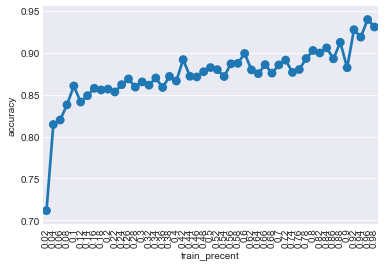

In [24]:
'''Here is the graph on the increase in classification accuracy with an increase in training data. I called the proportion as 
"diminishing" as soon as there was a generally flat point without still a clear indication of improvement immediately ahead. 
For me, this appears to be at about 0.6, but of course this is subjective. This shows that I should use the 0.6/0.4 split, 
which doesn't change the way in which I train and test, but at least gives me insight into why I am using these numbers, as 
opposed to using 0.6/0.4 just because that is convention
'''
%matplotlib inline
sns.set_style("darkgrid")
ax = sns.pointplot(y="accuracy", x="train_precent", data= ml_progress)
plt.xticks(rotation = 90)


In [25]:
'''Writing the csv file, so we don't have to if we restart the cells, and can maintain the data that we generated'''
ml_progress.to_csv('ml_progress.csv', sep=',')

In [26]:
'''Now that the model is trained, and we have our feature weights, I wanted to see if the phrase "Defense Wins Championships"
truly holds. In order to do this, I grouped the features into four groups: offense, defense, kicks, and penalties, while
also having a pandas data frame of the features and their respective weights
'''
featureImportances = pd.DataFrame({"index":df_labels.columns[:-1],"featureImportances":win_model.stages[1].featureImportances})
    
kicks= ['Kickoff Yard','Kickoff Ret','Kickoff','Field Goal Made','Off XP Kick Made','Off XP Kick Att','Field Goal Made',
        'Field Goal Att','Punt Ret Yard','Kickoff Onside','Kickoff Out-Of-Bounds','Red Zone Field Goal','Punt Yard',
       'Kickoff Touchback']
offense = ['Rush Yard','Rush Att','Pass Att','Points','1st Down Rush','Kickoff Ret Yard',
           'Red Zone TD','Time Of Possession','Pass Yard','Red Zone Att','Fourth Down Att','Pass Comp','Fumble',
          'Third Down Att','Fourth Down Conv','Third Down Conv','Pass Conv','Off 2XP Att','Punt Ret TD','Kickoff Ret TD',
          '1st Down Pass','Fumble Lost','Misc Ret TD','Misc Ret Yard','Rush TD','Pass TD','Punt Ret','Off 2XP Made','Misc Ret']
defense = ['Sack Yard','Int Ret Yard','Punt','Tackle For Loss Yard','Pass Broken Up','Fum Ret Yard','QB Hurry','Int Ret',
           'Fum Ret','Safety','Def 2XP Made','Kick/Punt Blocked','Fumble Forced','Pass Int','Sack','Tackle For Loss',
           'Tackle Assist','Tackle Solo','Fum Ret TD','Int Ret TD','Def 2XP Att']
penalty = ['1st Down Penalty','Penalty','Penalty Yard']


In [27]:
def find_category(index):
    if index in offense:
        return 'offense'
    if index in kicks:
        return 'kicks'
    if index in defense:
        return 'defense'
    if index in penalty:
        return 'penalty'
    
'''I added a column to the featureImportance table, where the value is the category in which the feature resides
as defined by the previously lists. We can then group all the features into their appropriate group, and sum the 
weights together'''
featureImportances['category'] = featureImportances.apply(lambda row : find_category(row['index']), axis = 1)
groups = featureImportances.groupby('category').agg('sum')
groups

,featureImportances
category,
defense,0.124719
kicks,0.462806
offense,0.403173
penalty,0.009302


In [28]:
labels = 'defense','kicks','offense', 'penalty'
sizes = [215, 130, 245, 210]
colors = ['grey', 'lightblue', 'darkorange', 'green']

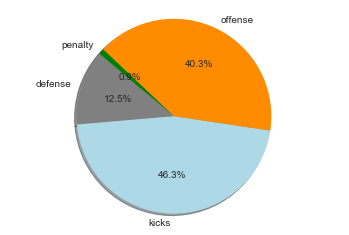

In [29]:
plt.pie(groups, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [30]:
groups

,featureImportances
category,
defense,0.124719
kicks,0.462806
offense,0.403173
penalty,0.009302


In [31]:
'''During one test, I found the feature Kickoff Yard to be extremely over-representative in feature weight. Therefore, 
I decided to retrain the model without it, and to see how well the model performs and then see the weights of the groups
without Kickoff Yard being use as a feature
'''

keep_without_ky = [col for col in keep if col != 'Kickoff Yard']

finalDF = filtered[keep_without_ky]
df_labels = spark.createDataFrame(finalDF)
win_assembler = VectorAssembler (inputCols = keep_without_ky[:-1], outputCol = 'features')
splits = df_labels.randomSplit([0.6, 0.4], 1234)
win_train = splits[0]
win_test = splits[1]
win_rf = RandomForestClassifier(featuresCol='features', labelCol='W/L', numTrees=10)
win_pipeline = Pipeline(stages=[win_assembler, win_rf])
win_model = win_pipeline.fit(win_train)
win_predictions = win_model.transform(win_test)
evaluator = MulticlassClassificationEvaluator(labelCol="W/L", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(win_predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.8631386861313869


In [32]:
featureImportances = pd.DataFrame({"index":keep_without_ky[:-1],"featureImportances":win_model.stages[1].featureImportances})   


In [38]:
#kicks = [col for col in kicks if col != 'Kickoff Yard']
featureImportances['category'] = featureImportances.apply(lambda row : find_category(row['index']), axis = 1)
groups = featureImportances.groupby('category').agg('sum')

In [34]:
labels = 'defense','kicks','offense', 'penalty'
sizes = [215, 130, 245, 210]
colors = ['grey', 'lightblue', 'darkorange', 'green']

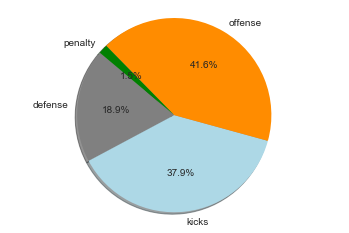

In [35]:
plt.pie(groups, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [36]:
sorted_features = featureImportances.sort_values('featureImportances',ascending = False)
sorted_features.head()

,featureImportances,index,category
36,0.158085,Kickoff,kicks
33,0.142567,Points,offense
26,0.097925,Off XP Kick Att,kicks
45,0.056536,Tackle For Loss Yard,defense
27,0.056359,Off XP Kick Made,kicks


In [37]:
groups

,featureImportances
category,
defense,0.189184
kicks,0.379294
offense,0.416067
penalty,0.015455


In [1]:
def changing_trees(df_labels):
    col= ['trees','accuracy']
    ml_list = []
    for i in range (71):
        print('On step {} out of 10'.format(i))
        splits = df_labels.randomSplit([.6, .4], 1234)
        win_train = splits[0]
        win_test = splits[1]
        win_rf = RandomForestClassifier(featuresCol='features', labelCol='W/L', numTrees=30 + i)
        win_pipeline = Pipeline(stages=[win_assembler, win_rf])
        win_model = win_pipeline.fit(win_train)
        win_predictions = win_model.transform(win_test)
        evaluator = MulticlassClassificationEvaluator(labelCol="W/L", predictionCol="prediction",
                                                  metricName="accuracy")
        accuracy = evaluator.evaluate(win_predictions)
        ml_list.append([30+i,accuracy])
    ml_progress = pd.DataFrame(ml_list,columns = col) 
    return ml_progress 

trees = changing_trees(df_labels)


IndentationError: unexpected indent (<ipython-input-1-2083ae715481>, line 2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70]), <a list of 71 Text xticklabel objects>)

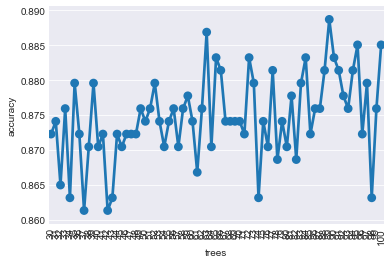

In [54]:
%matplotlib inline
sns.set_style("darkgrid")
ax = sns.pointplot(y="accuracy", x="trees", data= trees)
plt.xticks(rotation = 90)
